### Verify if the dstribution of best GP fits stays fixed

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 07-29-20
<br>**Short description:** This notebook will try replicate the set of experiments done w.r.t. the accuracy of the mock LCs standard deviation as done in [GP_mockLC_amp.ipynb](./GP_mockLC_amp.ipynb), and applying fitting on top (instead of directly measure the STD).

In [7]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# see if local stores mpl style, else use from src
try:
    plt.style.use('yu_basic')
except:
    mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)
%matplotlib inline

In [8]:
# import GP modules
from agntk.carma.CARMATerm import *
from agntk.lc.utils import *
from celerite import GP
import dask
from scipy.optimize import minimize

### 1. Examine the dependence of the error distribution on LC/tau ratio
We will test for 5 different $\tau$ values and for each we will simulate 1000 light curves from the prior distribution

In [9]:
# define log posterior function
def neg_log_prob(params, y, yerr, gp):
    gp.set_parameter_vector(params)
#     amp = gp.kernel.get_rms_amp()
#     model_std = np.sqrt(np.var(y) - np.var(yerr))
    
    # below add a prior using the estimated model std from light curve
    return -gp.log_likelihood(y)

In [45]:
# funtion to parallel LC simulation and fitting with Dask
@dask.delayed
def simLC_fit(tauErrArr, ampErrArr, tau, amp, seed=42, N=100, nLC=1000, duration=3650.0, errAmp=0.0, down=True, stdErrArr=None):
    
    # set random seed
    np.random.seed(seed)
    
    # init sim kernel
    kernel = DRW_term(np.log(amp), np.log(tau))
    gp_sim = GP(kernel)

    # first init 10K time stamps
    t = np.linspace(0, duration, 10000)
    yerr = np.random.normal(0, 1e-7, 10000) # give very tiny error
    
    # try if factorize, skip after 10 tries
    factor = True
    fact_num = 0
    
    while factor:
        try:
            gp_sim.compute(t, yerr)
            factor = False
        except Exception as e:
            fact_num += 1
            if fact_num > 10:
                print(e)
                print(f'Failed at seed {seed}!')
                return 1
    
    y = gp_sim.sample(size=nLC)
    ampErr = []
    tauErr = []
    stdErr = []
    
    for i in range(nLC):
    
        try:
            # downsample
            if down:
                mask1 = add_season(t)
                mask2 = downsample_byN(t[mask1], N) # randomly select N time stamps
                t_fit = t[mask1][mask2] 
                y_fit = y[i, :][mask1][mask2]
                yerr_fit = yerr[mask1][mask2]
            else:
                scale = int(10000/N)
                t_fit = t[::scale]
                y_fit = y[i, ::scale]
                yerr_fit = yerr[::scale]
                stdErr.append((np.std(y_fit)-amp)/amp)

            ## start fitting
            # initialize parameter in the possible range
            init_tau = np.exp(np.random.uniform(1, np.log(1000), 1)[0])
            init_amp = np.random.uniform(0, 0.35, 1)[0]

            kernel_fit = DRW_term(np.log(init_amp), np.log(init_tau))
            gp_fit = GP(kernel_fit)
            gp_fit.compute(t_fit, yerr_fit)

            initial_params = gp_fit.get_parameter_vector()
            bounds = gp_fit.get_parameter_bounds()

            r = minimize(neg_log_prob, initial_params, method="L-BFGS-B", bounds=bounds, \
                         args=(y_fit, yerr_fit, gp_fit))

            # compute pecentage err for each LC and add to list
            input_param = np.array([amp, tau])
            err = 100*(np.exp(r.x) - input_param)/input_param
            ampErr.append(err[0])
            tauErr.append(err[1])
            
        except Exception as e:
            print(e)
            print(f'Failed fitting for LC:{i} with nPts:{N}')
            ampErr.append(0)
            tauErr.append(0)
            continue
        
    # assign result of result array
    ampErrArr[:] = ampErr
    tauErrArr[:] = tauErr
    
    if not down and stdErrArr is not None:
        stdErrArr[:] = stdErr
    
    return 0

In [65]:
# init empty array to store errors
nLC = 1000
nTaus = 5
tauErrArr = np.empty((nTaus, nLC))
ampErrArr = np.empty((nTaus, nLC))
stdErrArr = np.empty_like(tauErrArr)

dask_rt = []
taus = np.logspace(1, np.log10(500), 5)

for i, tau in enumerate(taus):
    dask_rt.append(simLC_fit(tauErrArr[i,:], ampErrArr[i,:], tau, 0.25, nLC=nLC, N=1000, down=False, stdErrArr=stdErrArr[i,:]))

total = dask.delayed(sum)(dask_rt)
sum_n = total.compute()
print(sum_n)

/home/agntk/src/agntk/carma/CARMATerm.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.exp(2 * log_sigma), 1 / np.exp(log_tau))


0


### 1.2 Let's plot the result, see any significant difference in error distribution

Text(0.5, 0, 'Percentage error')

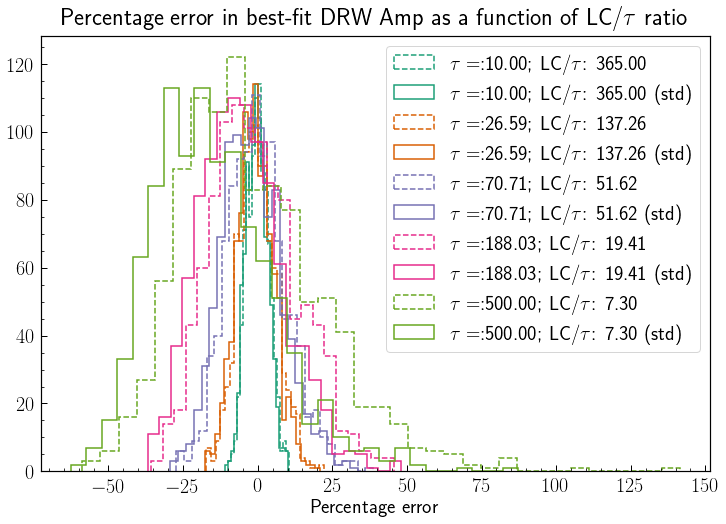

In [74]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(ampErrArr):
    _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, linestyle='--', \
                 label=f'$\\tau=$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f}', \
                 color=mpl.cm.Dark2.colors[i])
    _ = plt.hist(stdErrArr[i,:]*100, bins='fd', histtype='step', linewidth=1.5, \
                 label=f'$\\tau=$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f} (std)',\
                 color=mpl.cm.Dark2.colors[i])
plt.title('Percentage error in best-fit DRW Amp as a function of LC/$\\tau$ ratio')
plt.legend()
plt.xlabel('Percentage error')

Text(0.5, 0, 'Percentage error')

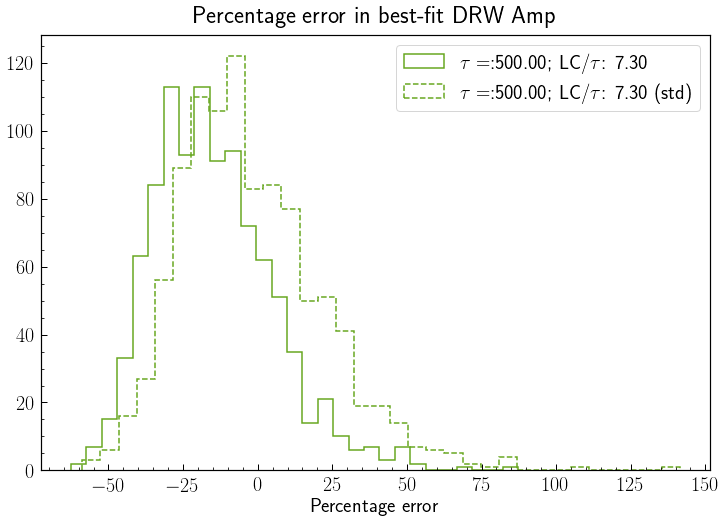

In [75]:
fig = plt.figure(figsize=(12,8))
i = 4
_ = plt.hist(stdErrArr[i,:]*100, bins='fd', histtype='step', linewidth=1.5, \
             label=f'$\\tau=$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f}',\
             color=mpl.cm.Dark2.colors[i])
_ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, linestyle='--', \
             label=f'$\\tau=$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f} (std)', \
             color=mpl.cm.Dark2.colors[i])
plt.title('Percentage error in best-fit DRW Amp ')
plt.legend()
plt.xlabel('Percentage error')

<span style='color:red'> __Note:__ </span> Seems like fitting is helping to find the correct amplitude (for large $\tau$ value), in other words, the maximum likelihood solution is taking advantage of the recurrent features in the light curves and provided a better estimate of the intrinsic variability amplitude than what gave by the standard deviation.

Text(0.5, 0, 'Percentage error')

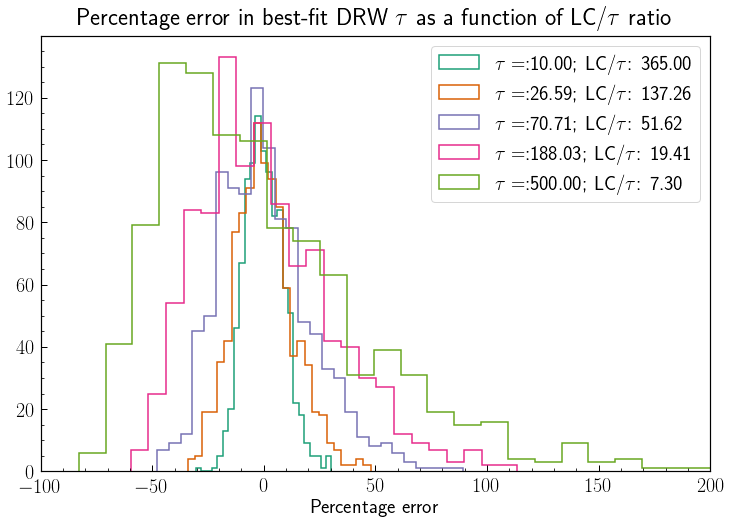

In [77]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(tauErrArr):
    _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, \
                 label=f'$\\tau=$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f}',\
                 color=mpl.cm.Dark2.colors[i])
plt.title('Percentage error in best-fit DRW $\\tau$ as a function of LC/$\\tau$ ratio')
plt.xlim(-100, 200)
plt.legend()
plt.xlabel('Percentage error')

### 2. Let's examin the effect of the number of data points in LC

In [51]:
# init empty array to store errors
nLC = 1000
n_points = [80, 120, 200, 400, 800, 1600]
n_combo = len(n_points)
tauErrArrPt = np.empty((n_combo, nLC))
ampErrArrPt = np.empty((n_combo, nLC))
stdErrArrPt = np.empty_like(tauErrArrPt)

dask_rt = []

for i, n_pt in enumerate(n_points):
    dask_rt.append(simLC_fit(tauErrArrPt[i,:], ampErrArrPt[i,:], 110, 0.25, nLC=nLC, N=n_pt, down=False, stdErrArr=stdErrArrPt[i,:]))

total = dask.delayed(sum)(dask_rt)
sum_n = total.compute()
print(sum_n)

/home/conda/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


failed to factorize or solve matrix
Failed fitting for LC:610 with nPts:200


/home/agntk/src/agntk/carma/CARMATerm.py:61: RuntimeWarning: overflow encountered in exp
  return (np.exp(2 * log_sigma), 1 / np.exp(log_tau))


0


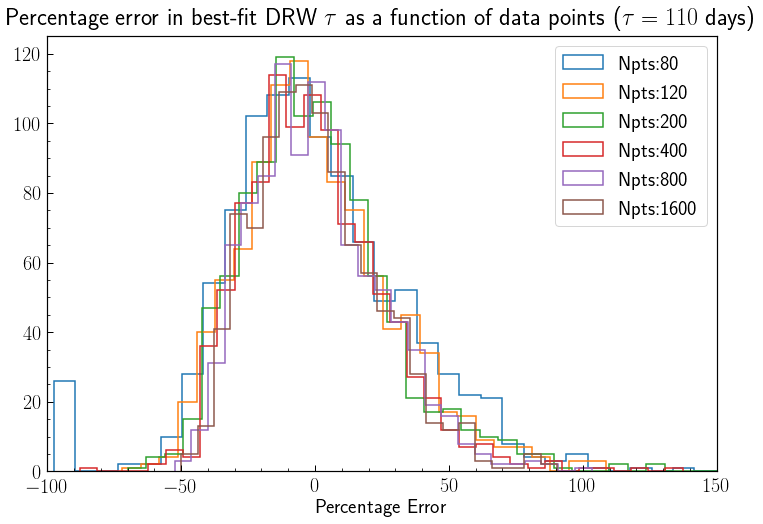

In [54]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(tauErrArrPt):
    _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, label=f'Npts:{n_points[i]}')
plt.title('Percentage error in best-fit DRW $\\tau$ as a function of data points ($\\tau=110$ days)')
plt.xlabel('Percentage Error')
plt.xlim(-100, 150)
plt.legend()

<span style='color:red'> __Note:__ </span> Earlier saw numerically unstable solutions for npts = 50. With ~ 100 light curves give an error about -100% in $\tau$. Ths may indicate that low number of data points is likely lead to unstable/inaccurate best-fit solution. From the plot shown above, we can see even with 80 data points (in blue), we still get a lot of bad fits.

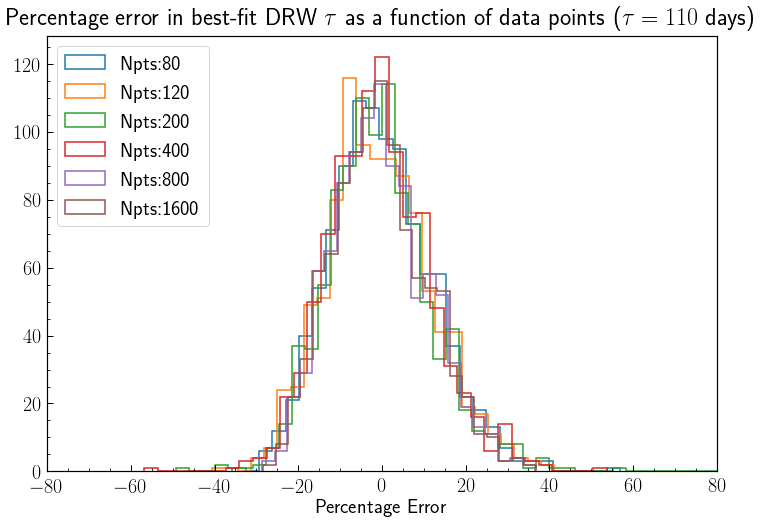

In [56]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(ampErrArrPt):
    _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, label=f'Npts:{n_points[i]}')
plt.title('Percentage error in best-fit DRW Amplitude as a function of data points ($\\tau=110$ days)')
plt.xlabel('Percentage Error')
plt.xlim(-80, 80)
plt.legend()

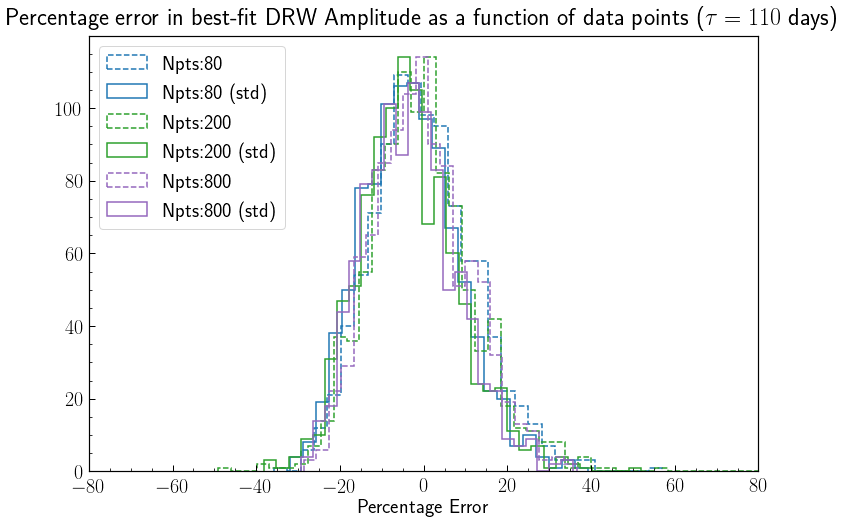

In [90]:
fig = plt.figure(figsize=(12,8))

for i, err in enumerate(ampErrArrPt):
    if i in [0,2,4]:
        _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, linestyle='--', \
                     label=f'Npts:{n_points[i]}', color=mpl.cm.tab10.colors[i])
        _ = plt.hist(stdErrArrPt[i]*100, bins='fd', histtype='step', linewidth=1.5, \
                     label=f'Npts:{n_points[i]} (std)', color=mpl.cm.tab10.colors[i])
plt.title('Percentage error in best-fit DRW Amplitude as a function of data points ($\\tau=110$ days)')
plt.xlabel('Percentage Error')
plt.xlim(-80, 80)
plt.legend()

<span style='color:red'> __Conclusion:__ </span> The number of data points in a light curve doesn't affect the accuracy of the best-fit DRW amplitude at all, the percentage error of best-fit amplitude is also in good agreement from that determined using light curve standard deviation. On the other hand, the best-fit $\tau$ is more likely to be affected by low number of data points (e.g. $<$100), more investigations needed on this part. 

### 3. Now test the effects of seasonal gaps and LSST-like cadence (100 obs)

In [67]:
# init empty array to store errors
nLC = 1000
nTaus = 5
tauErrArrSG = np.empty((nTaus, nLC))
ampErrArrSG = np.empty((nTaus, nLC))
stdErrArrSG = np.empty_like(tauErrArrSG)

dask_rt = []
taus = np.logspace(1, np.log10(500), 5)

for i, tau in enumerate(taus):
    dask_rt.append(simLC_fit(tauErrArrSG[i,:], ampErrArrSG[i,:], tau, 0.25, nLC=nLC, N=100))

total = dask.delayed(sum)(dask_rt)
sum_n = total.compute()
print(sum_n)

0


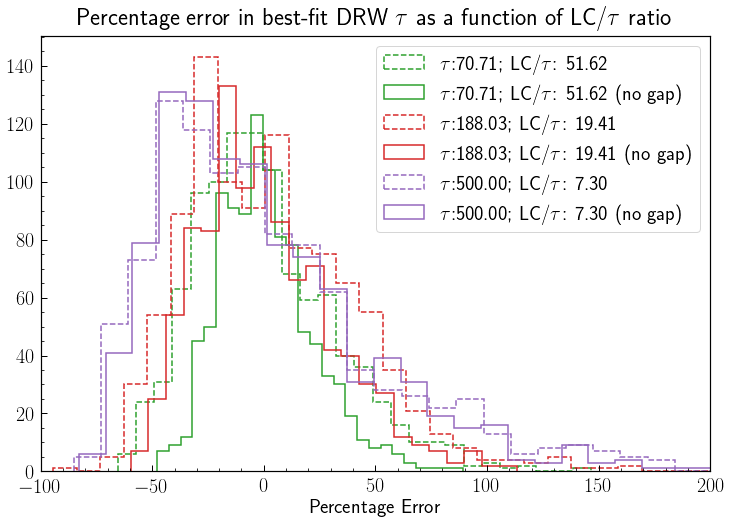

In [97]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(tauErrArrSG):
    if i in [2, 3, 4]:
        _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, linestyle='--', color=mpl.cm.tab10.colors[i],\
                     label=f'$\\tau$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f}')
        _ = plt.hist(tauErrArr[i], bins='fd', histtype='step', linewidth=1.5, color=mpl.cm.tab10.colors[i],\
                     label=f'$\\tau$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f} (no gap)')
plt.title('Percentage error in best-fit DRW $\\tau$ as a function of LC/$\\tau$ ratio')
plt.xlabel('Percentage Error')
plt.xlim(-100, 200)
plt.legend()

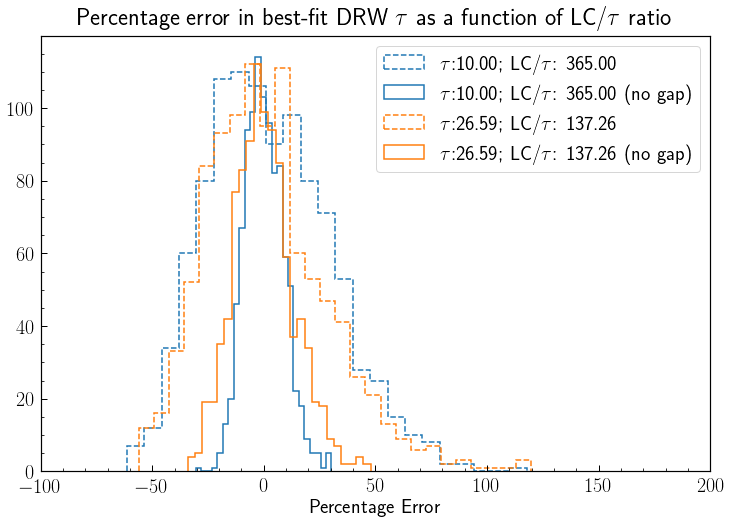

In [98]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(tauErrArrSG):
    if i in [0,1]:
        _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, linestyle='--', color=mpl.cm.tab10.colors[i],\
                     label=f'$\\tau$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f}')
        _ = plt.hist(tauErrArr[i], bins='fd', histtype='step', linewidth=1.5, color=mpl.cm.tab10.colors[i],\
                     label=f'$\\tau$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f} (no gap)')
plt.title('Percentage error in best-fit DRW $\\tau$ as a function of LC/$\\tau$ ratio')
plt.xlabel('Percentage Error')
plt.xlim(-100, 200)
plt.legend()

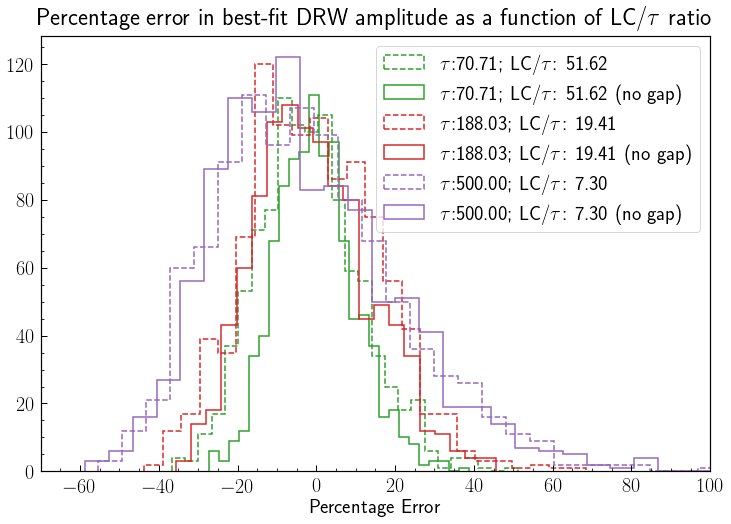

In [105]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(ampErrArrSG):
    if i in [2, 3, 4]:
        _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, linestyle='--', color=mpl.cm.tab10.colors[i],\
                     label=f'$\\tau$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f}')
        _ = plt.hist(ampErrArr[i], bins='fd', histtype='step', linewidth=1.5, color=mpl.cm.tab10.colors[i],\
                     label=f'$\\tau$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f} (no gap)')
plt.title('Percentage error in best-fit DRW amplitude as a function of LC/$\\tau$ ratio')
plt.xlabel('Percentage Error')
plt.xlim(-70, 100)
plt.legend()

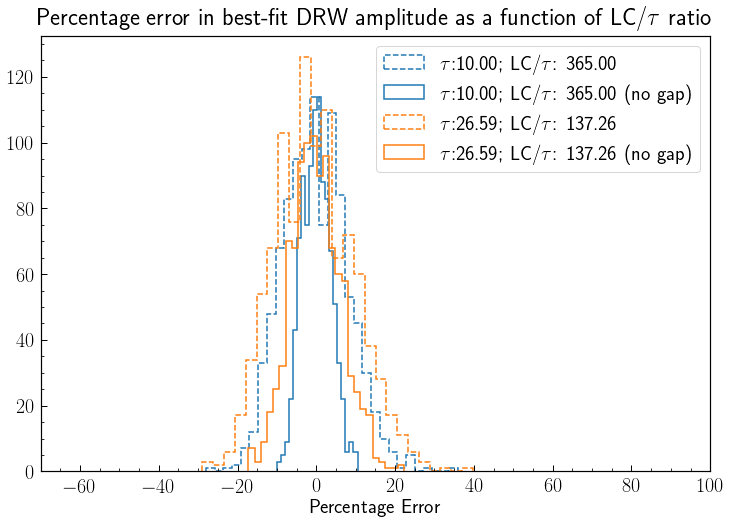

In [106]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(ampErrArrSG):
    if i in [0, 1]:
        _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, linestyle='--', color=mpl.cm.tab10.colors[i],\
                     label=f'$\\tau$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f}')
        _ = plt.hist(ampErrArr[i], bins='fd', histtype='step', linewidth=1.5, color=mpl.cm.tab10.colors[i],\
                     label=f'$\\tau$:{taus[i]:.2f}; LC/$\\tau$: {3650/taus[i]:.2f} (no gap)')
plt.title('Percentage error in best-fit DRW amplitude as a function of LC/$\\tau$ ratio')
plt.xlabel('Percentage Error')
plt.xlim(-70, 100)
plt.legend()

<span style='color:red'> __Conclusion:__ </span> The result shown in this section is similar to what we got from simply comparing the standard deviations of the light curves, that is the seasonal gaps doesn't shift and change the error distribution (as compared to uniform dense cadence) and it only broaden it. The broadening effect is quite large if the average cadence (LC length/# of obs) is shorter than the characteristic timescale, and such an effect will become negligible as $\tau$ becomes much larger than the average cadence.

<span style='color:red'> __Important:__ </span> Another finding is that, even when the $\tau$ is right about the length of the seasonal gap (~ 180 days), the addition of the gap doesn't introduce much additional error. 